# Try-it 9.2: Predicting Wages

This activity is meant to summarize your work with regularized regression models. You will use your earlier work with data preparation and pipelines together with what you've learned with grid searches to determine an optimal model. In addition to the prior strategies, this example is an excellent opportunity to utilize the TransformedTargetRegressor estimator in scikitlearn.



# The Data

This dataset is loaded from the openml resource library. Originally from census data, the data contains wage and demographic information on 534 individuals. From the dataset documentation here

The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. 

# Task
Build regression models to predict WAGE. Incorporate the categorical features and transform the target using a logarithm. Build Ridge models and consider some different amounts of regularization.

After fitting your model, interpret the model and try to understand what features led to higher wages. Consider using permutation_importance that you encountered in module 8. Discuss your findings in the class forum.

For an in depth example discussing the perils of interpreting the coefficients see the example in scikitlearn examples here.

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
cf.go_offline()
%matplotlib inline

In [146]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder,PolynomialFeatures,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
set_config(display="diagram")

from sklearn.decomposition import PCA,FastICA
from sklearn.compose import ColumnTransformer,make_column_selector,make_column_transformer,TransformedTargetRegressor
from sklearn.utils import shuffle
from sklearn.inspection import permutation_importance

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.datasets import fetch_openml

In [10]:
wages = fetch_openml(data_id=534, as_frame=True)
df=wages.frame

In [11]:
df

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,5.10,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,4.95,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,6.67,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,4.00,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,7.50,35.0,White,Other,Other,Married
...,...,...,...,...,...,...,...,...,...,...,...
529,18.0,no,male,5.0,not_member,11.36,29.0,White,Professional,Other,Unmarried
530,12.0,no,female,33.0,not_member,6.10,51.0,Other,Professional,Other,Married
531,17.0,no,female,25.0,member,23.25,48.0,Other,Professional,Other,Married
532,12.0,yes,male,13.0,member,19.88,31.0,White,Professional,Other,Married


# EDA

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    float64 
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    float64 
 4   UNION       534 non-null    category
 5   WAGE        534 non-null    float64 
 6   AGE         534 non-null    float64 
 7   RACE        534 non-null    category
 8   OCCUPATION  534 non-null    category
 9   SECTOR      534 non-null    category
 10  MARR        534 non-null    category
dtypes: category(7), float64(4)
memory usage: 21.4 KB


The data set has a 534 entries and 11 features. Some of the data type of the features are floats and some of them are category.

In [13]:
df.describe()

,EDUCATION,EXPERIENCE,WAGE,AGE
count,534.000000,534.000000,534.000000,534.000000
mean,13.018727,17.822097,9.024064,36.833333
std,2.615373,12.379710,5.139097,11.726573
min,2.000000,0.000000,1.000000,18.000000
25%,12.000000,8.000000,5.250000,28.000000
50%,12.000000,15.000000,7.780000,35.000000
75%,15.000000,26.000000,11.250000,44.000000
max,18.000000,55.000000,44.500000,64.000000


This is a statistical descriptive of the numerical values of the features 

# Checking the Categorical features 

Check the categorical features are nominal, ordinal, or interval

* Nominal datas are, have no intrinsic ordering.
* Ordinal datas are, have an intrinsci ordering.
*interval datas are, similar to ordinal, except intervals between the values of the numerical variable equally spaced

In [15]:
# Sex column
df['SEX'].unique()

['female', 'male']
Categories (2, object): ['female', 'male']

The sex column is a nominal category. Need to use OneHotEncoder to get dummies 

In [18]:
#Union column
df['UNION'].unique()

['not_member', 'member']
Categories (2, object): ['member', 'not_member']

Again the Union column is a nominal category. Need to use OneHotEncoder to get dummies

In [20]:
#Race column
df['RACE'].unique()

['Hispanic', 'White', 'Other']
Categories (3, object): ['Hispanic', 'Other', 'White']

Again the Racecolumn is a nominal category. Need to use OneHotEncoder to get dummies

In [21]:
#Occupation column
df['OCCUPATION'].unique()

['Other', 'Management', 'Sales', 'Clerical', 'Service', 'Professional']
Categories (6, object): ['Clerical', 'Management', 'Other', 'Professional', 'Sales', 'Service']

The Occupation column is an ordinal column and I use OrdinalEncoder

In [22]:
#Sector column
df['SECTOR'].unique()

['Manufacturing', 'Other', 'Construction']
Categories (3, object): ['Construction', 'Manufacturing', 'Other']

In [23]:
df['MARR'].unique()

['Married', 'Unmarried']
Categories (2, object): ['Married', 'Unmarried']

MARR is a nominal column

In [24]:
df['SOUTH'].unique()

['no', 'yes']
Categories (2, object): ['no', 'yes']

SOUTH is a nominal column

In [28]:
df.columns

Index(['EDUCATION', 'SOUTH', 'SEX', 'EXPERIENCE', 'UNION', 'WAGE', 'AGE',
       'RACE', 'OCCUPATION', 'SECTOR', 'MARR'],
      dtype='object')

In [29]:
#list of categorical features 
nominal_column=['SOUTH', 'SEX', 'UNION','RACE','MARR']
ordinal_column=['OCCUPATION']

# checking missing values

In [31]:
#to check missing value, used the isnull() function
df.isnull().sum()

EDUCATION     0
SOUTH         0
SEX           0
EXPERIENCE    0
UNION         0
WAGE          0
AGE           0
RACE          0
OCCUPATION    0
SECTOR        0
MARR          0
dtype: int64

By using isnull to check a missing values,I donot get any missing values

# Data Visualization

#Seaborn plots

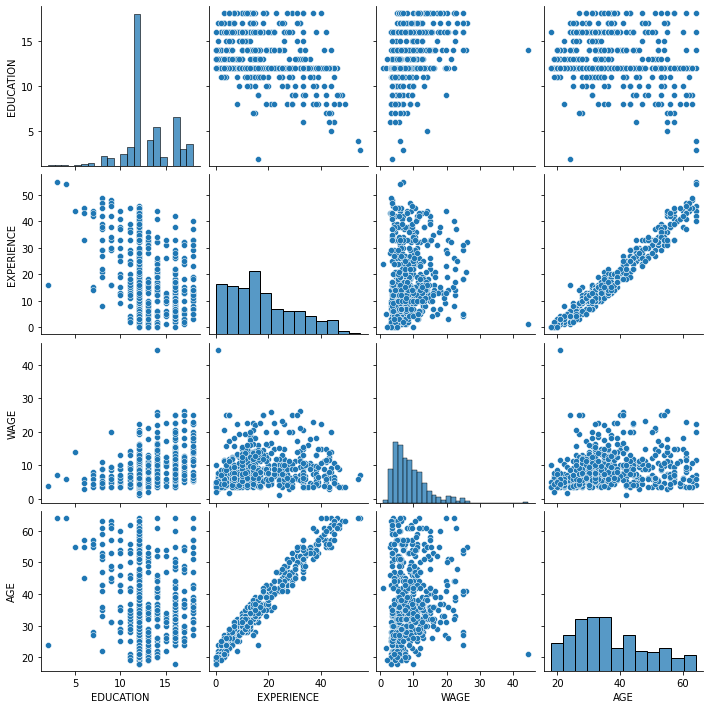

In [32]:
#Used pairplot to see all datas
sns.pairplot(df)

From the seaborn pairplot, the AGE and EXIRIENCE have a strong correlation. And others have a no strong correlation to each other,

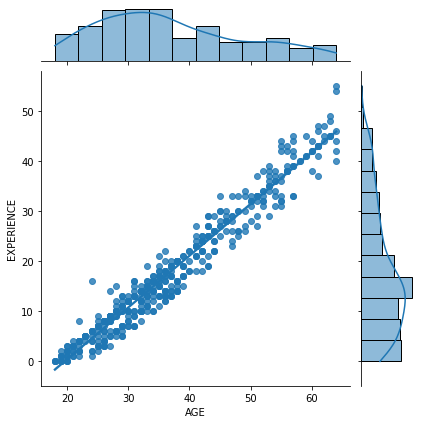

In [33]:
# seaborn joint plot
sns.jointplot(data=df, x='AGE',y='EXPERIENCE', kind='reg')

# Histogram for wage to different logarthnic functions, AGE, and Experience

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



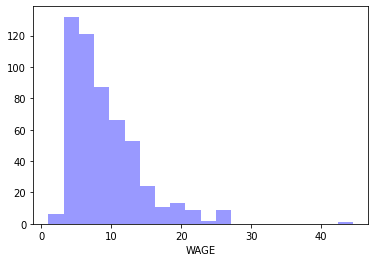

In [120]:
#histogram of the wages
sns.distplot(df['WAGE'], bins=20, kde=False,color='Blue')

In [74]:
import math

In [75]:
df['WAGE']

0       5.10
1       4.95
2       6.67
3       4.00
4       7.50
       ...  
529    11.36
530     6.10
531    23.25
532    19.88
533    15.38
Name: WAGE, Length: 534, dtype: float64

In [76]:
df_log=np.log1p(df['WAGE'])
df_log

0      1.808289
1      1.783391
2      2.037317
3      1.609438
4      2.140066
         ...   
529    2.514465
530    1.960095
531    3.188417
532    3.038792
533    2.796061
Name: WAGE, Length: 534, dtype: float64

In [77]:
np.exp(df_log)

0       6.10
1       5.95
2       7.67
3       5.00
4       8.50
       ...  
529    12.36
530     7.10
531    24.25
532    20.88
533    16.38
Name: WAGE, Length: 534, dtype: float64

Text(0, 0.5, 'Logarthmic Wages')

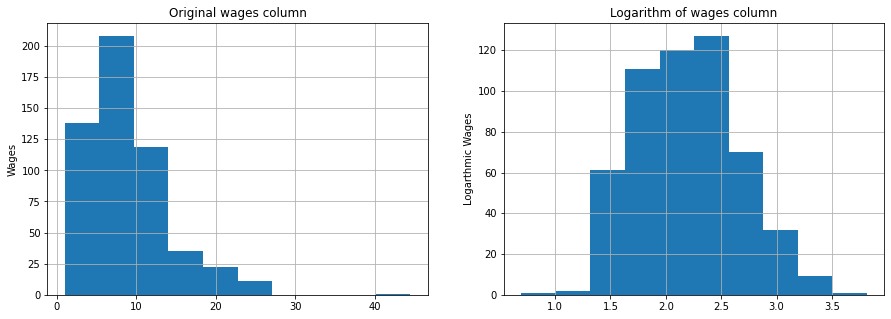

In [52]:
#log1p
#The log1p () function computes the value of log (1+x) accurately even for tiny argument x.
fig, ax =plt.subplots(nrows=1,ncols=2, figsize=(15,5))

ax[0].hist(df['WAGE'])
ax[0].set_title('Original wages column')
ax[0].grid()
ax[0].set_ylabel('Wages')


ax[1].hist(np.log1p(df['WAGE']))
ax[1].grid()
ax[1].set_title('Logarithm of wages column')
ax[1].set_ylabel('Logarthmic Wages')

Text(0, 0.5, 'Logarthmic Wages')

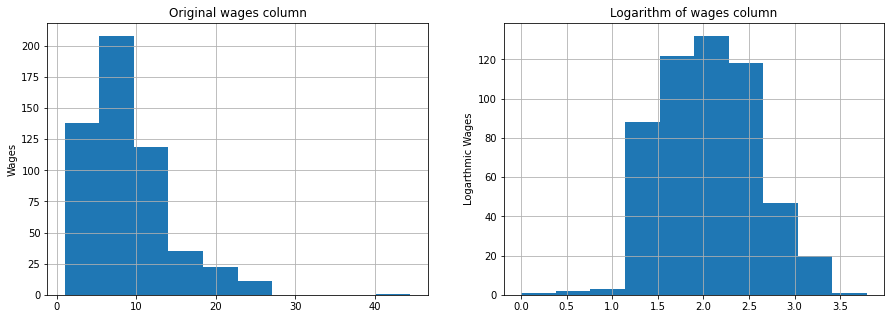

In [53]:
#log
fig, ax =plt.subplots(nrows=1,ncols=2, figsize=(15,5))

ax[0].hist(df['WAGE'])
ax[0].set_title('Original wages column')
ax[0].grid()
ax[0].set_ylabel('Wages')


ax[1].hist(np.log(df['WAGE']))
ax[1].grid()
ax[1].set_title('Logarithm of wages column')
ax[1].set_ylabel('Logarthmic Wages')

Text(0, 0.5, 'Logarthmic Wages')

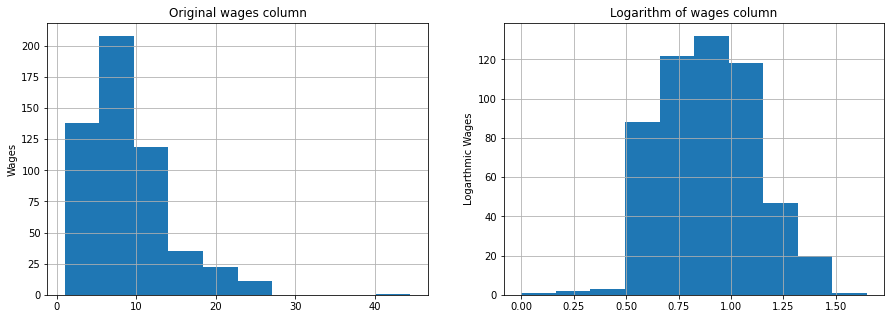

In [54]:
#log10
fig, ax =plt.subplots(nrows=1,ncols=2, figsize=(15,5))

ax[0].hist(df['WAGE'])
ax[0].set_title('Original wages column')
ax[0].grid()
ax[0].set_ylabel('Wages')


ax[1].hist(np.log10(df['WAGE']))
ax[1].grid()
ax[1].set_title('Logarithm of wages column')
ax[1].set_ylabel('Logarthmic Wages')

Text(0, 0.5, 'Logarthmic AGE')

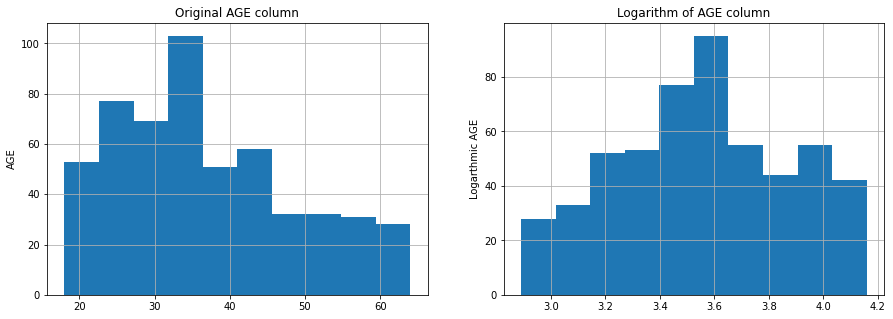

In [94]:
# AGES
#log
fig, ax =plt.subplots(nrows=1,ncols=2, figsize=(15,5))

ax[0].hist(df['AGE'])
ax[0].set_title('Original AGE column')
ax[0].grid()
ax[0].set_ylabel('AGE')


ax[1].hist(np.log(df['AGE']))
ax[1].grid()
ax[1].set_title('Logarithm of AGE column')
ax[1].set_ylabel('Logarthmic AGE')

Text(0.5, 1.0, 'Experience data set')

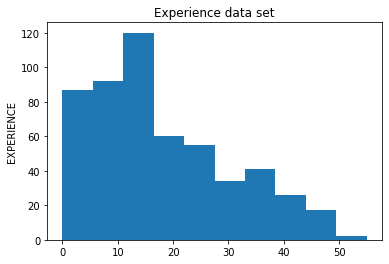

In [103]:
#Excperience histogram
plt.hist(df['EXPERIENCE'])
plt.ylabel('EXPERIENCE')
plt.title('Experience data set')

#barplots

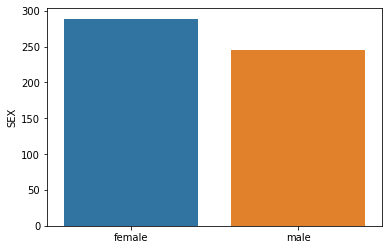

In [93]:
# barplot to determine the number of females and males 
df['SEX'].value_counts()
sns.barplot(x=df['SEX'].unique(),y=df['SEX'].value_counts())

From the bar plot above, the number of Female (289) is more than number of male (245).

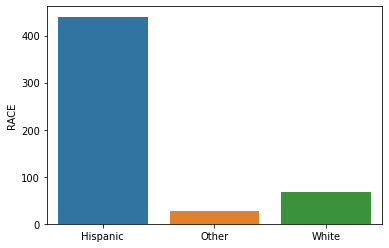

In [102]:
#RACE
sns.barplot(x=df['RACE'].unique(),y=df['RACE'].value_counts())

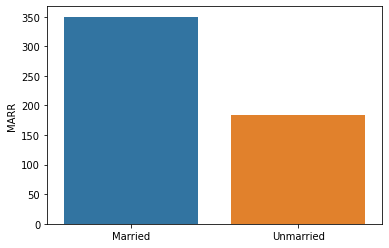

In [106]:
#MARR barplots
sns.barplot(x=df['MARR'].unique(),y=df['MARR'].value_counts())

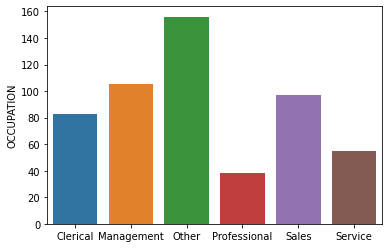

In [107]:
#Experience barplots
sns.barplot(x=df['OCCUPATION'].unique(),y=df['OCCUPATION'].value_counts())

From the above boxplot, the averages age of a Famel is around 35 and for male around 33.

#Boxplot

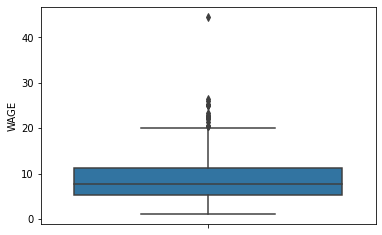

In [121]:
#WAGE boxplot
sns.boxplot(y=df['WAGE'])

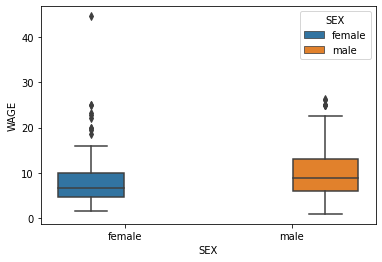

In [117]:
# WAGE boxplots
sns.boxplot(data=df, y='WAGE',x='SEX', hue='SEX')

The male sex have higher wage than the females.

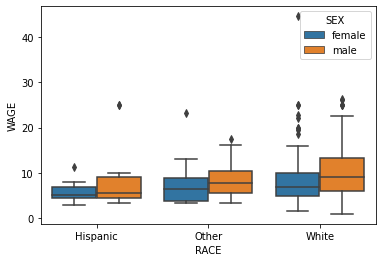

In [118]:
#boxplots
sns.boxplot(data=df, y='WAGE',x='RACE', hue='SEX')

from the boxplot above, the white Race are get higher wages than the others in both sex and Hispanic less than any other Races

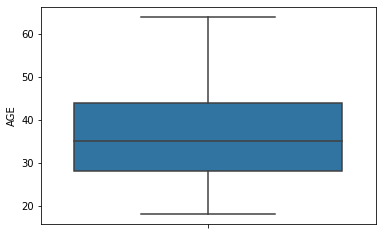

In [122]:
#AGE boxplot
sns.boxplot(y=df['AGE'])

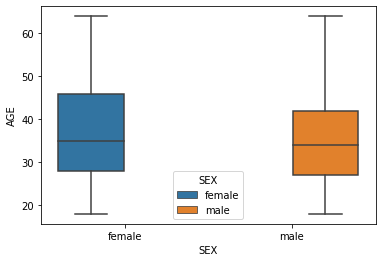

In [123]:
# AGE boxplots
sns.boxplot(data=df, y='AGE',x='SEX', hue='SEX')

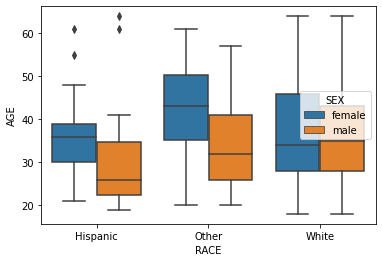

In [204]:
#boxplots
sns.boxplot(data=df, y='AGE',x='RACE', hue='SEX')

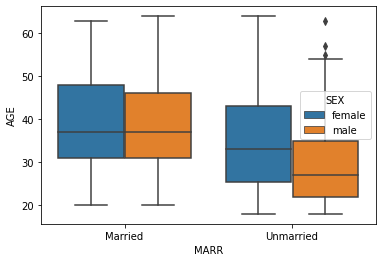

In [205]:
#boxplots
sns.boxplot(data=df, y='AGE',x='MARR', hue='SEX')

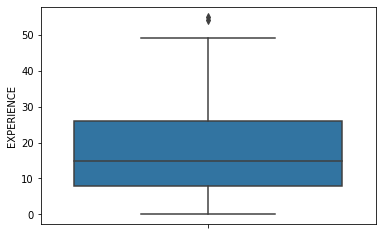

In [125]:
#Experience boxplot
sns.boxplot(y=df['EXPERIENCE'])

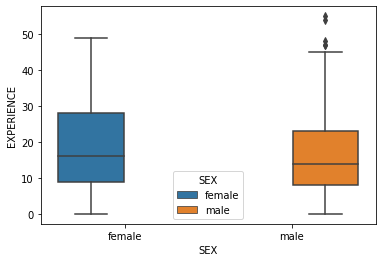

In [126]:
# EXPERIENCE boxplots
sns.boxplot(data=df, y='EXPERIENCE',x='SEX', hue='SEX')

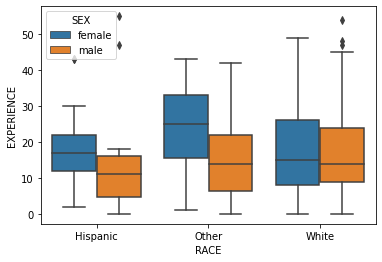

In [127]:
#boxplots
sns.boxplot(data=df, y='EXPERIENCE',x='RACE', hue='SEX')

Eventhough, the hispanic, and other than white people are more experienced, the white people, still the white people are get more wages.

#seaborn violinplot

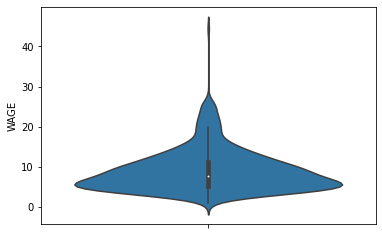

In [130]:
#WAGE 
sns.violinplot(y= df['WAGE'])

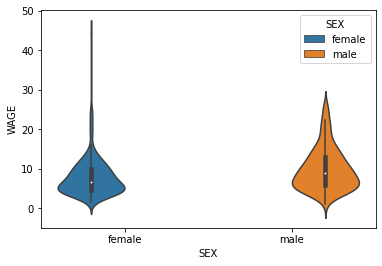

In [131]:
# WAGE boxplots
sns.violinplot(data=df, y='WAGE',x='SEX', hue='SEX')

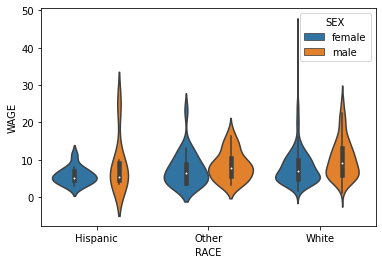

In [132]:
#boxplots
sns.violinplot(data=df, y='WAGE',x='RACE', hue='SEX')

# Seaborn Heatmap and clustermap

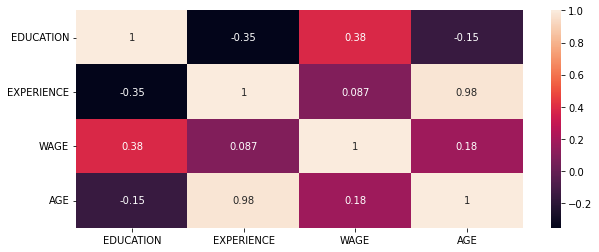

In [137]:
plt.figure(figsize=(10,4))
sns.heatmap(df.corr(),annot=True)

The AGE and EXPERIENCE have a very strong correlation 0.98.

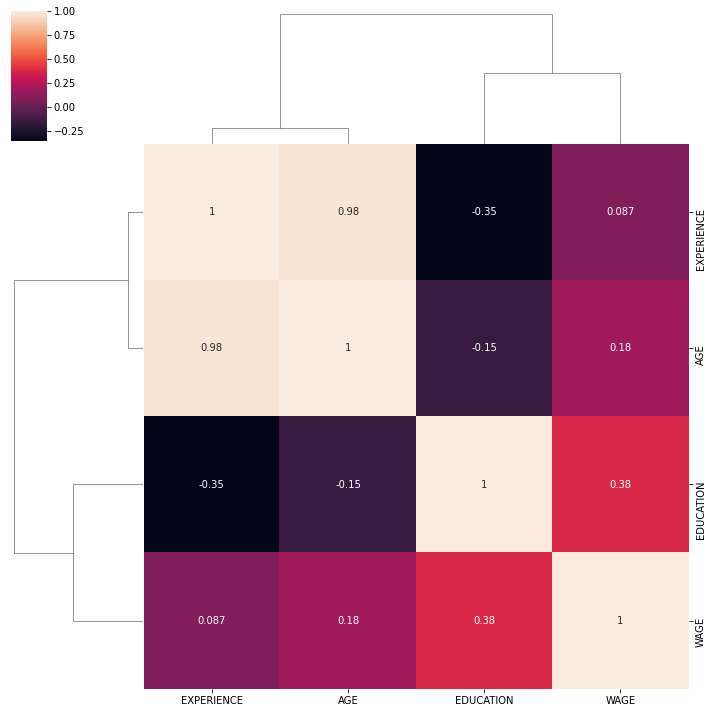

In [139]:
sns.clustermap(df.corr(), annot=True)

# Prepare the data

In [151]:
X=df.drop(['SECTOR','OCCUPATION','WAGE'], axis=1)
y=np.log1p(df['WAGE'])

# Splitting the data into train and test set

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating a make_column_transformer

In [153]:
transformer=make_column_transformer((OneHotEncoder(sparse=False),nominal_column))

# First find the best polynomial degrees

In [156]:
train_mses=[]
test_mses=[]
for i in range(1,5):
  pipe1=Pipeline(
               steps=[('transformer',transformer),
                      ('poly_feaures',PolynomialFeatures(degree=i,include_bias=False)),
                      ('scaler',StandardScaler()),
                      ('lr_model',LinearRegression())
                                               ] 

                                               )
  pipe1.fit(X_train,y_train)
  train_preds1=pipe1.predict(X_train)
  test_preds1=pipe1.predict(X_test)
  train_mses.append(mean_squared_error(y_train,train_preds1))
  test_mses.append(mean_squared_error(y_test,test_preds1))

In [157]:
print(train_mses.index(min(train_mses)))
print(test_mses.index(min(test_mses)))

3
0


Degree 3 is the best model for our data

# Apply Ridge model

In [159]:
ridge_pipe=Pipeline(
               steps=[('transformer',transformer),
                      ('poly_feaures',PolynomialFeatures(degree=3,include_bias=False)),
                      ('scaler',StandardScaler()),
                      ('ridge_model',Ridge())
                                          ] 

                                        )
ridge_pipe.fit(X_train,y_train)
train_ridge_preds=ridge_pipe.predict(X_train)
test_ridge_preds=ridge_pipe.predict(X_test)
train_ridge_mses =mean_squared_error(y_train,train_ridge_preds)
test_ridge_mses =mean_squared_error(y_test,test_ridge_preds)

In [160]:
# Coeficients
print(ridge_pipe.named_steps['ridge_model'].coef_)
print(ridge_pipe.named_steps['ridge_model'].intercept_)

[ 2.22787068e-03 -2.22787068e-03 -2.27916140e-03  2.27916140e-03
  3.44506362e-03 -3.44506362e-03 -1.34221344e-03 -1.08636664e-03
  1.72955702e-03  1.99589408e-03 -1.99589408e-03  2.22787068e-03
  0.00000000e+00  2.03982231e-03  1.04109865e-04  2.95467758e-03
 -1.41904727e-04 -5.91470018e-04  1.50089087e-03  1.41572315e-03
  6.50743636e-04  1.55865090e-03 -2.22787068e-03 -6.30252515e-03
  2.95010316e-03  1.51861259e-03 -2.99634731e-03 -1.29587094e-03
 -3.49611447e-03 -2.66585095e-05  1.57254794e-03 -5.75665272e-03
 -2.27916140e-03  0.00000000e+00  1.74196147e-03 -3.13978140e-03
  2.81879583e-03 -1.87130442e-03 -2.48180736e-03 -3.17057122e-03
  9.02654213e-04  2.27916140e-03  2.78685442e-03  3.44462377e-04
 -4.86765793e-03  1.36450471e-04  3.79810750e-03  5.05354989e-03
 -3.19337408e-03  3.44506362e-03  0.00000000e+00  8.87979300e-03
 -1.10996595e-03  1.93933820e-03  3.58883883e-03  5.05170535e-04
 -3.44506362e-03 -5.86865459e-03 -5.08683214e-04  1.16666384e-05
 -6.04046107e-04 -2.33518

In [161]:
#apply to GridSearchCV
param_dict_ridge = {'ridge_model__alpha':[0.1,1,10]}
ridge_grid=GridSearchCV(estimator=ridge_pipe,param_grid=param_dict_ridge)
ridge_grid.fit(X_train,y_train)
train_grid_ridge_pred=ridge_grid.predict(X_train)
test_grid_ridge_pred=ridge_grid.predict(X_test)

In [162]:
#Calculate the mean squared error
train_mse_ridge=mean_squared_error(y_train,train_grid_ridge_pred)
test_mse_ridge=mean_squared_error(y_test,test_grid_ridge_pred)

print(f'train mean squared erro: {train_mse_ridge}')
print(f'test mean squared erro: {test_mse_ridge}')

train mean squared erro: 0.16744867633358326
test mean squared erro: 0.23066624831388366


In [169]:
ridge_grid.best_score_

0.013456727203516738

In [194]:
ridge_grid.param_grid

{'ridge_model__alpha': [0.1, 1, 10]}

In [164]:
best_estimator=ridge_grid.best_estimator_
best_estimator

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'MARR'])])),
                ('poly_feaures',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('scaler', StandardScaler()),
                ('ridge_model', Ridge(alpha=10))])

In [167]:
best_model=best_estimator.named_steps['ridge_model']
best_model

Ridge(alpha=10)

# Apply SequentailFeature Selection

In [173]:
seq_pipe=Pipeline(
               steps=[('transformer',transformer),
                      ('poly_feaures',PolynomialFeatures(degree=3,include_bias=False)),
                      ('scaler',StandardScaler()),
                      ('selector',SequentialFeatureSelector(estimator=Lasso())),
                      ('lr_model',LinearRegression())
                                          ] 

                                        )

In [174]:
#apply to GridSearchCV
param_dict = {'selector__n_features_to_select': [2, 3, 4, 5]}
seq_grid=GridSearchCV(estimator=seq_pipe,param_grid=param_dict)
seq_grid.fit(X_train,y_train)
train_seq_pred=seq_grid.predict(X_train)
test_seq_pred=seq_grid.predict(X_test)

In [175]:
seq_grid.best_score_

0.06456487001773067

The ridge model score 0.013456727203516738 is smaller than the sequential fature selection score 0.06456487001773067. This is ridge model predicts better than the sequential feature selection model.

In [196]:
#Calculate the mean squared error
train_mse_seq=mean_squared_error(y_train,train_seq_pred)
test_mse_seq=mean_squared_error(y_test,test_seq_pred)

print(f'train mean squared erro: {train_mse_seq}')
print(f'test mean squared erro: {test_mse_seq}')

train mean squared erro: 0.1894861527000161
test mean squared erro: 0.2070276972207411


In [177]:
best_estimator=seq_grid.best_estimator_
best_estimator

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['SOUTH', 'SEX', 'UNION',
                                                   'RACE', 'MARR'])])),
                ('poly_feaures',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('scaler', StandardScaler()),
                ('selector',
                 SequentialFeatureSelector(estimator=Lasso(),
                                           n_features_to_select=5)),
                ('lr_model', LinearRegression())])

In [178]:
best_estimator.named_steps['lr_model']

LinearRegression()

# Apply  permutation_importance on Ridge model

In [192]:
r = permutation_importance(ridge_grid, X_test, y_test,n_repeats=1,random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

UNION   0.104 +/- 0.000
SEX     0.075 +/- 0.000
SOUTH   0.027 +/- 0.000
RACE    0.004 +/- 0.000


# Using TransformedTargetRegressor estimator in scikitlearn.

In [193]:
#using StandardScaler
# prepare the model with input scaling
ridge_tte_pipe=Pipeline(
               steps=[('transformer',transformer),
                      ('poly_feaures',PolynomialFeatures(degree=3,include_bias=False)),
                      ('scaler',StandardScaler()),
                      ('ridge_model',Ridge())
                                          ] 

                                        )



#pipeline = Pipeline(steps=[('normalize', MinMaxScaler()), ('model', HuberRegressor())])
# prepare the model with target scaling
model = TransformedTargetRegressor(regressor=ridge_tte_pipe, transformer=StandardScaler())
model.fit(X_train,y_train)
tte_train_pred=model.predict(X_train)
tte_test_pred=model.predict(X_test)

In [195]:
tte_train_mses=mean_squared_error(y_train,tte_train_pred)
tte_test_mses=mean_squared_error(y_test,tte_test_pred)
print(f'train mean squared erro for TransformedTargetRegressor: {tte_train_mses}')
print(f'test mean squared erro for TransformedTargetRegressor: {tte_test_mses}')

train mean squared erro for TransformedTargetRegressor: 0.16742786417494238
test mean squared erro for TransformedTargetRegressor: 0.2357350624077549


In [197]:
from sklearn.preprocessing import MinMaxScaler

In [202]:
#Using MinMaxScaler
# prepare the model with input scaling
ridge_tteminmax_pipe=Pipeline(
               steps=[('transformer',transformer),
                      ('poly_feaures',PolynomialFeatures(degree=3,include_bias=False)),
                      ('scaler',MinMaxScaler()),
                      ('ridge_model',Ridge())
                                          ] 

                                        )

model_minmax = TransformedTargetRegressor(regressor=ridge_tte_pipe, transformer=MinMaxScaler())
model_minmax.fit(X_train,y_train)
tte_train_pred_minmax=model_minmax.predict(X_train)
tte_test_pred_minmax=model_minmax.predict(X_test)

In [203]:
tte_train_mses_minmax=mean_squared_error(y_train,tte_train_pred_minmax)
tte_test_mses_minmax=mean_squared_error(y_test,tte_test_pred_minmax)
print(f'train mean squared erro for TransformedTargetRegressor: {tte_train_mses_minmax}')
print(f'test mean squared erro for TransformedTargetRegressor: {tte_test_mses_minmax}')

train mean squared erro for TransformedTargetRegressor: 0.1674278641749424
test mean squared erro for TransformedTargetRegressor: 0.23573506240775582
